In [2]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

from aux import Ephemeral, sgmd
from disp import set_font_size, set_n_x_ticks
from ntwk import LIFNtwk


DT = 0.0005  # s
T_M_PC = 0.05  # s
E_L_PC = -0.068  # V
V_TH_PC = -0.036  # V
V_R_PC = -0.068  # V
T_R_PC = 0.008  # s

ES_SYN = {'E': 0.0}  # V
TS_SYN = {'E': 0.002}  # s

WS_RCR = {'E': np.zeros((1, 1))}

R_MAX = 20  # Hz
L_PL = .15  # m
R_SGM = 10  # Hz

SGM_MAX = 2
B_SGM = 1/1  # 1/Hz

NONLIN = lambda r: 1 + (SGM_MAX - 1)*sgmd(B_SGM*(r - R_SGM))

E = Ephemeral()

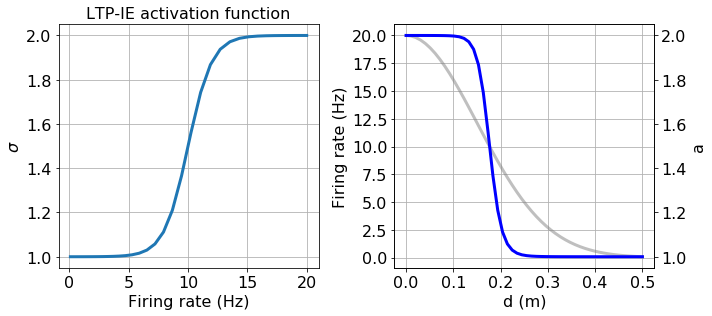

In [6]:
E.d = np.linspace(0, .5)
E.r = R_MAX * np.exp(-.5*(E.d**2)/(L_PL**2))

E.sgm = NONLIN(E.r)

# plots
E.fig, E.axs = plt.subplots(1, 2, figsize=(10, 4.5), tight_layout=True)

# nonlinearity
E.axs[0].plot(E.r, E.sgm, lw=3)
E.axs[0].set_xlabel('Firing rate (Hz)')
E.axs[0].set_ylabel('$\sigma$')
E.axs[0].set_title('LTP-IE activation function')

E.axs[0].grid()

# place-tuning and a-tuning
E.axs[1].plot(E.d, E.r, lw=3, color='gray', alpha=.5)
E.axs[1].set_xlabel('d (m)')
E.axs[1].set_ylabel('Firing rate (Hz)')

E.axs[1].grid()

E.ax_twin = E.axs[1].twinx()
E.ax_twin.plot(E.d, E.sgm, color='b', lw=3)
E.ax_twin.set_ylabel('a')


for E.ax in list(E.axs) + [E.ax_twin]:
    set_font_size(E.ax, 16)
    
E.clear()

# Demonstrate effect of LTP-IE on gate inputs

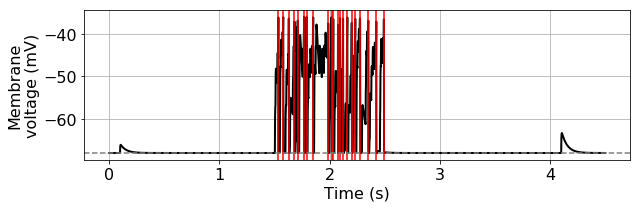

In [7]:
np.random.seed(0)

E.R_PL = 100
E.W_PC_G = 0.008

# pre-LTP-IE & spks
E.ws_up = {'E': np.array([[0.05, E.W_PC_G]])}

E.t = np.arange(0, 4, DT)
E.spks_up = np.zeros((len(E.t), 2), dtype=int)

# first G inp
E.spks_up[int(.1/DT), 1] = 1

# spk-evoking inp
E.spks_up_g = np.random.poisson(E.R_PL*DT, int(1/DT))
E.t_idx_start = int(1.5/DT)
E.spks_up[E.t_idx_start:E.t_idx_start+len(E.spks_up_g), 0] = E.spks_up_g

E.ntwk = LIFNtwk(
    t_m=np.array([T_M_PC]),
    e_l=np.array([E_L_PC]),
    v_th=np.array([V_TH_PC]),
    v_r=np.array([V_R_PC]),
    t_r=np.array([T_R_PC]),
    es_syn=ES_SYN,
    ts_syn=TS_SYN,
    ws_up=E.ws_up,
    ws_rcr=WS_RCR)

E.rsp = E.ntwk.run(spks_up=E.spks_up, dt=DT)

# post-LTP-IE

E.ws_up = {'E': np.array([[0.04, 0.02]])}

E.t = np.arange(0, .5, DT)
E.spks_up = np.zeros((len(E.t), 2), dtype=int)
E.spks_up[int(round(.1/DT)), 1] = 1

E.ntwk = LIFNtwk(
    t_m=np.array([T_M_PC]),
    e_l=np.array([E_L_PC]),
    v_th=np.array([V_TH_PC]),
    v_r=np.array([V_R_PC]),
    t_r=np.array([T_R_PC]),
    es_syn=ES_SYN,
    ts_syn=TS_SYN,
    ws_up=E.ws_up,
    ws_rcr=WS_RCR)

E.rsp_post = E.ntwk.run(spks_up=E.spks_up, dt=DT)

E.t = np.concatenate([E.rsp.ts, E.rsp_post.ts+(len(E.rsp.ts)*DT)])
E.vs = np.concatenate([E.rsp.vs, E.rsp_post.vs])
E.spks = np.concatenate([E.rsp.spks, E.rsp_post.spks])

# make fig
E.fig, E.ax = plt.subplots(1, 1, figsize=(9, 3), tight_layout=True)

E.ax.plot(E.t, 1000 * E.vs, color='k', lw=2)

for E.t_idx_spk in E.spks[:, 0].nonzero()[0]:
    E.t_spk = DT * E.t_idx_spk
    E.ax.axvline(E.t_spk, color='r', lw=1.5)

E.ax.axhline(1000*E_L_PC, color='gray', ls='--')
    
E.ax.set_xlabel('Time (s)')
E.ax.set_ylabel('Membrane\nvoltage (mV)')

E.ax.grid()
set_font_size(E.ax, 16)

E.clear()

# Demo of effect of diff levels of LTP-IE on Vm under random G input

R_G = 75 Hz
..............................
R_G = 125 Hz
..............................
R_G = 175 Hz
..............................


/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:88: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


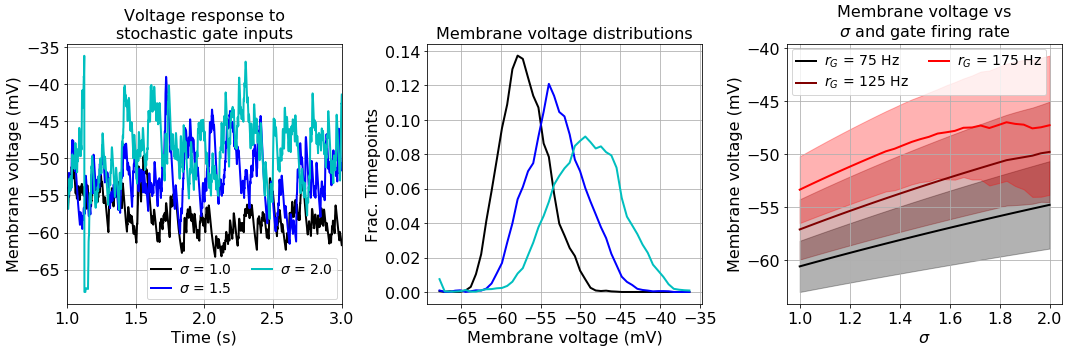

In [5]:
E.SGMS_XMPL = [1, .5*(1 + SGM_MAX), SGM_MAX]
E.W_PC_G = 0.008

E.SGMS = np.linspace(1, SGM_MAX, 30)
E.R_G = 125
E.R_GS = [75, 125, 175]
E.V_BINS = np.linspace(-68, -36, 50)  # mV
E.V_BINCS = .5 * (E.V_BINS[:-1] + E.V_BINS[1:])  # mV

E.T = 15  # s

np.random.seed(0)

E.rsps_xmpl = []

E.t = np.arange(0, E.T, DT)

# example runs
for E.sgm in E.SGMS_XMPL:
    E.ws_up = {'E': E.sgm*E.W_PC_G*np.ones((1, 1))}
    E.spks_up = np.random.poisson(E.R_G*DT, (len(E.t), 1))
    
    E.ntwk = LIFNtwk(
        t_m=np.array([T_M_PC]),
        e_l=np.array([E_L_PC]),
        v_th=np.array([V_TH_PC]),
        v_r=np.array([V_R_PC]),
        t_r=np.array([T_R_PC]),
        es_syn=ES_SYN,
        ts_syn=TS_SYN,
        ws_up=E.ws_up,
        ws_rcr=WS_RCR)
    
    E.rsp = E.ntwk.run(spks_up=E.spks_up, dt=DT)
    E.rsps_xmpl.append(E.rsp)

# voltage vs R_G and SGM    
## loop over R_G
E.v_means = []
E.v_stds = []

for E.r_g in E.R_GS:
    print('R_G = {} Hz'.format(E.r_g))
    
    # build gate stim
    E.spks_up = np.random.poisson(E.r_g*DT, (len(E.t), 1))
    
    # loop over A
    E.v_means_ = []
    E.v_stds_ = []
    
    for E.sgm in E.SGMS:
        sys.stdout.write('.')
        
        E.ws_up = {'E': E.sgm*E.W_PC_G*np.ones((1, 1))}
        
        E.ntwk = LIFNtwk(
            t_m=np.array([T_M_PC]),
            e_l=np.array([E_L_PC]),
            v_th=np.array([V_TH_PC]),
            v_r=np.array([V_R_PC]),
            t_r=np.array([T_R_PC]),
            es_syn=ES_SYN,
            ts_syn=TS_SYN,
            ws_up=E.ws_up,
            ws_rcr=WS_RCR)
    
        E.rsp = E.ntwk.run(spks_up=E.spks_up, dt=DT)
        E.v_means_.append(np.nanmean(E.rsp.vs[:, 0]))
        E.v_stds_.append(np.nanstd(E.rsp.vs[:, 0]))
    
    E.v_means.append(np.array(E.v_means_))
    E.v_stds.append(np.array(E.v_stds_))
    
    print('')


# make plots
E.X_LIM_XMPL = [1, 3]
E.COLORS = ['k', 'b', 'c']
E.COLORS_R_G = ['k', (.5, 0, 0), (1, 0, 0)]

E.fig, E.axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

# example traces and voltage distributions
for E.rsp, E.color in zip(E.rsps_xmpl, E.COLORS):
    E.axs[0].plot(E.rsp.ts, 1000 * E.rsp.vs, lw=2, color=E.color)
    E.cts, E.bins = np.histogram(1000 * E.rsp.vs[:, 0], bins=E.V_BINS, normed=True)
    
    E.axs[1].plot(E.V_BINCS, E.cts, lw=2, color=E.color)

E.axs[0].set_xlabel('Time (s)')    
E.axs[0].set_ylabel('Membrane voltage (mV)')
E.axs[0].set_title('Voltage response to\nstochastic gate inputs')
E.axs[0].legend(['$\sigma$ = {0:.1f}'.format(E.sgm) for E.sgm in E.SGMS_XMPL], ncol=2)

E.axs[0].grid()

E.axs[0].set_xlim(E.X_LIM_XMPL)
set_n_x_ticks(E.axs[0], 5, 1, 3)

E.axs[1].set_xlabel('Membrane voltage (mV)')
E.axs[1].set_ylabel('Frac. Timepoints')
E.axs[1].set_title('Membrane voltage distributions')

E.axs[1].grid()

for E.r_g, E.v_means_, E.v_stds_, E.color in zip(E.R_GS, E.v_means, E.v_stds, E.COLORS_R_G):
    E.axs[2].plot(E.SGMS, 1000*E.v_means_, lw=2, color=E.color)
    E.axs[2].fill_between(E.SGMS, 1000*(E.v_means_ - E.v_stds_), 1000*(E.v_means_ + E.v_stds_), color=E.color, alpha=.3)
    
E.axs[2].set_xlabel('$\sigma$')
E.axs[2].set_ylabel('Membrane voltage (mV)')
E.axs[2].set_title('Membrane voltage vs\n$\sigma$ and gate firing rate')
    
E.axs[2].grid()

E.axs[2].legend(['$r_G$ = {0:.0f} Hz'.format(E.r_g) for E.r_g in E.R_GS], loc='upper left', ncol=2)

for E.ax in E.axs:
    set_font_size(E.ax, 16, legend_font_size=14)

# Demo effect of potentiation on spike response probability

In [7]:
E.clear()

E.T_XMPL = 2
E.COLORS_XMPL = ['k', 'c']
E.SGMS_XMPL = [1, 2]
E.R_G_XMPL = 125
E.I_AMP_XMPL = .0008

E.W_PC_G_XMPL = 0.008
E.W_PC_GS = [0.004, .008, .012, .016]

E.I_DUR = .01
E.ITVL = .25

np.random.seed(0)

# xmpl
E.t_xmpl = np.arange(0, E.T_XMPL, DT)

E.rsp_xmpls = []

## mk i_ext trgs
E.i_ext_xmpl = np.zeros((len(E.t_xmpl), 1))

for E.t_i_ext in np.arange(E.ITVL, E.T_XMPL, E.ITVL):

    E.t_idx_start = int(E.t_i_ext/DT)
    E.t_idx_end = E.t_idx_start + int(E.I_DUR/DT)

    E.i_ext_xmpl[E.t_idx_start:E.t_idx_end, 0] = E.I_AMP_XMPL

for E.sgm in E.SGMS_XMPL:
    # mk ntwk
    E.ws_up = {'E': E.sgm*E.W_PC_G_XMPL*np.ones((1, 1))}
    
    E.ntwk = LIFNtwk(
        t_m=np.array([T_M_PC]),
        e_l=np.array([E_L_PC]),
        v_th=np.array([V_TH_PC]),
        v_r=np.array([V_R_PC]),
        t_r=np.array([T_R_PC]),
        es_syn=ES_SYN,
        ts_syn=TS_SYN,
        ws_up=E.ws_up,
        ws_rcr=WS_RCR)
    
    # mk G spks
    E.spks_up = np.random.poisson(E.R_G_XMPL*DT, (len(E.t_xmpl), 1))
    
    E.rsp = E.ntwk.run(spks_up=E.spks_up, dt=DT, i_ext=E.i_ext_xmpl)
    E.rsp.sgm = E.sgm
    E.rsp_xmpls.append(E.rsp)


# p_spk vs sgm
E.R_G = 125
E.I_AMP = .0008
E.SGMS = np.linspace(1, 2, 30)
E.T_WDW = 0.01

E.T = 125

E.t = np.arange(0, E.T, DT)

## mk G spks
E.spks_up = np.random.poisson(E.R_G*DT, (len(E.t), 1))

## mk i_ext trgs
E.i_ext = np.zeros((len(E.t), 1))
E.t_i_exts = np.arange(E.ITVL, E.T, E.ITVL)
E.n_i_ext = len(E.t_i_exts)

for E.t_i_ext in E.t_i_exts:
        
    E.t_idx_start = int(E.t_i_ext/DT)
    E.t_idx_end = E.t_idx_start + int(E.I_DUR/DT)

    E.i_ext[E.t_idx_start:E.t_idx_end, 0] = E.I_AMP


E.spk_probs = []
E.spk_prob_nulls = []

for E.w_pc_g in E.W_PC_GS:
    print('W_PC_G = {}'.format(E.w_pc_g))
    E.spk_probs_ = []
    E.spk_prob_nulls_ = []

    for E.sgm in E.SGMS:
        sys.stdout.write('.')

        # mk ntwk
        E.ws_up = {'E': E.sgm*E.w_pc_g*np.ones((1, 1))}

        E.ntwk = LIFNtwk(
            t_m=np.array([T_M_PC]),
            e_l=np.array([E_L_PC]),
            v_th=np.array([V_TH_PC]),
            v_r=np.array([V_R_PC]),
            t_r=np.array([T_R_PC]),
            es_syn=ES_SYN,
            ts_syn=TS_SYN,
            ws_up=E.ws_up,
            ws_rcr=WS_RCR)

        # run ntwk
        E.rsp = E.ntwk.run(spks_up=E.spks_up, dt=DT, i_ext=E.i_ext)

        # calc prob of i_ext-trgd spks
        E.spk_ct = 0

        for E.t_i_ext in E.t_i_exts:
            E.t_mask = (E.t_i_ext <= E.t) & (E.t < E.t_i_ext + E.T_WDW)
            E.spk_ct += int(E.rsp.spks[E.t_mask, :].sum() > 0)

        E.spk_probs_.append(E.spk_ct/E.n_i_ext)

        # run ntwk w/ no i_ext
        E.rsp = E.ntwk.run(spks_up=E.spks_up, dt=DT)

        # calc prob of i_ext-trgd spks
        E.spk_ct = 0

        for E.t_i_ext in E.t_i_exts:
            E.t_mask = (E.t_i_ext <= E.t) & (E.t < E.t_i_ext + E.T_WDW)
            E.spk_ct += int(E.rsp.spks[E.t_mask, :].sum() > 0)

        E.spk_prob_nulls_.append(E.spk_ct/E.n_i_ext)
        
    E.spk_probs.append(E.spk_probs_)
    E.spk_prob_nulls.append(E.spk_prob_nulls_)
    print('')


E.spk_probs = np.array(E.spk_probs)
E.spk_prob_nulls = np.array(E.spk_prob_nulls)

W_PC_G = 0.004
..............................
W_PC_G = 0.008
..............................
W_PC_G = 0.012
..............................
W_PC_G = 0.016
..............................


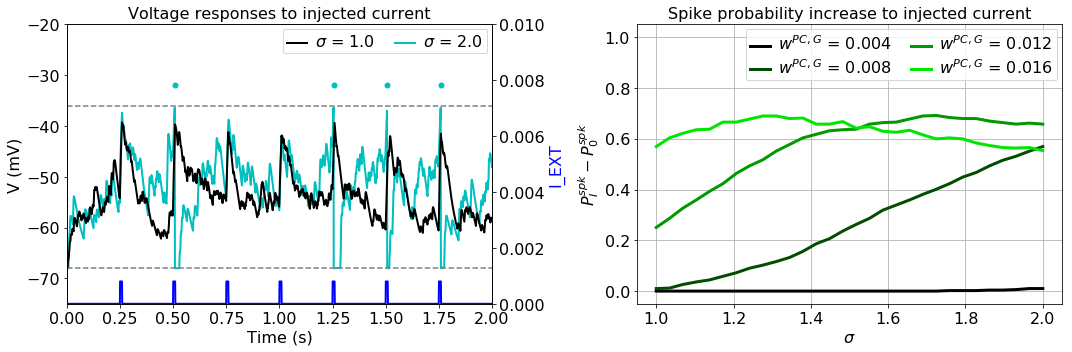

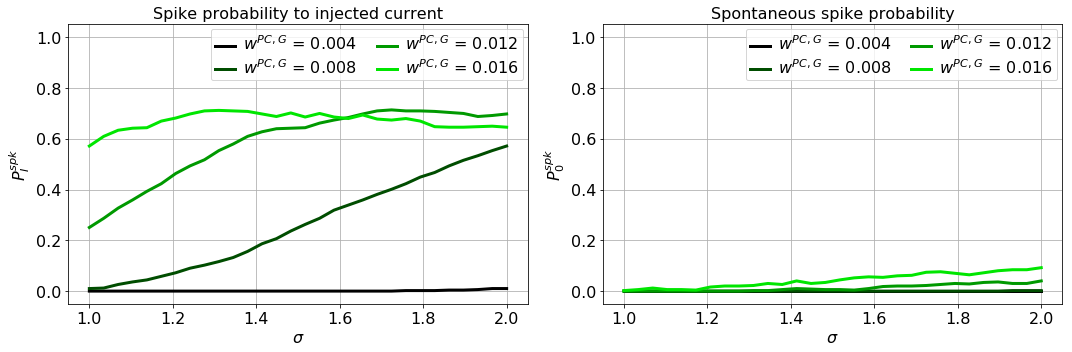

In [9]:
# mk plots
E.COLORS_W_PC_G = [(0, 0, 0), (0, .3, 0), (0, .6, 0), (0, .9, 0)]
E.fig, E.axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

# xmpl traces
E.hs = []

for E.ctr, (E.rsp, E.color) in enumerate(zip(E.rsp_xmpls, E.COLORS_XMPL)):
    
    E.label = '$\sigma$ = {0:.1f}'.format(E.rsp.sgm)
    
    E.h = E.axs[0].plot(
        E.t_xmpl, 1000*E.rsp.vs[:, 0], lw=2, color=E.color, label=E.label, zorder=(1-E.ctr))[0]
    E.hs.append(E.h)

    for E.spk_t_idx in E.rsp.spks[:, 0].nonzero()[0]:
        E.spk_t = E.spk_t_idx * DT
        E.y_spk = 1000*V_TH_PC + 2 + E.ctr*2
        E.axs[0].scatter(E.spk_t, E.y_spk, lw=0, c=E.color)
    
E.axs[0].axhline(1000*V_TH_PC, color='gray', ls='--')
E.axs[0].axhline(1000*V_R_PC, color='gray', ls='--')

E.axs[0].set_ylim(-75, -20)

E.axs[0].set_xlabel('Time (s)')
E.axs[0].set_ylabel('V (mV)')
E.axs[0].set_title('Voltage responses to injected current')
E.axs[0].legend(handles=E.hs, loc='upper right', ncol=2)

E.ax_twin = E.axs[0].twinx()
E.ax_twin.plot(E.t_xmpl, E.rsp.i_ext, lw=2, color='b')
E.ax_twin.set_ylim(0, .01)
E.ax_twin.set_ylabel('I_EXT', color='b')

E.axs[0].set_xlim(0, 2)

E.hs = []

for E.spk_probs_, E.spk_prob_nulls_, E.w_pc_g, E.color in zip(
        E.spk_probs, E.spk_prob_nulls, E.W_PC_GS, E.COLORS_W_PC_G):
    
    label = '{} = {}'.format('$w^{PC, G}$', E.w_pc_g)
    E.h = E.axs[1].plot(E.SGMS, E.spk_probs_ - E.spk_prob_nulls_, color=E.color, lw=3, label=label)[0]
    E.hs.append(E.h)

E.axs[1].set_ylim(-.05, 1.05)
E.axs[1].set_xlabel('$\sigma$')
E.axs[1].set_ylabel('$P^{spk}_{I} - P^{spk}_0$')
E.axs[1].set_title('Spike probability increase to injected current')
E.axs[1].legend(handles=E.hs, loc='best', ncol=2)

E.axs[1].grid()

for E.ax in list(E.axs) + [E.ax_twin]:
    set_font_size(E.ax, 16)
    
E.fig, E.axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

E.hs = []

for E.spk_probs_, E.spk_prob_nulls_, E.w_pc_g, E.color in zip(
        E.spk_probs, E.spk_prob_nulls, E.W_PC_GS, E.COLORS_W_PC_G):
    
    label = '{} = {}'.format('$w^{PC, G}$', E.w_pc_g)
    E.h = E.axs[0].plot(E.SGMS, E.spk_probs_, color=E.color, lw=3, label=label)[0]
    E.hs.append(E.h)

E.axs[0].set_ylim(-.05, 1.05)
E.axs[0].set_xlabel('$\sigma$')
E.axs[0].set_ylabel('$P^{spk}_{I}$')
E.axs[0].set_title('Spike probability to injected current')
E.axs[0].legend(handles=E.hs, loc='best', ncol=2)

E.hs = []

for E.spk_probs_, E.spk_prob_nulls_, E.w_pc_g, E.color in zip(
        E.spk_probs, E.spk_prob_nulls, E.W_PC_GS, E.COLORS_W_PC_G):
    
    label = '{} = {}'.format('$w^{PC, G}$', E.w_pc_g)
    E.h = E.axs[1].plot(E.SGMS, E.spk_prob_nulls_, color=E.color, lw=3, label=label)[0]
    E.hs.append(E.h)

E.axs[1].set_ylim(-.05, 1.05)
E.axs[1].set_xlabel('$\sigma$')
E.axs[1].set_ylabel('$P^{spk}_0$')
E.axs[1].set_title('Spontaneous spike probability')
E.axs[1].legend(handles=E.hs, loc='best', ncol=2)

for E.ax in E.axs:
    E.ax.grid()
    set_font_size(E.ax, 16)

## Explanation of $P^{spk}_I$ plateau for high $w_0^{PC,G}$

In [10]:
E.clear()

E.T_XMPL = 25
E.COLORS_XMPL = ['k', 'c']
E.SGMS_XMPL = [1, 2]
E.R_G_XMPL = 125
E.I_AMP_XMPL = .0008

E.W_PC_G_XMPL = 0.016

E.I_DUR = .01
E.ITVL = .25

np.random.seed(0)

# xmpl
E.t_xmpl = np.arange(0, E.T_XMPL, DT)

E.rsp_xmpls = []

## mk i_ext trgs
E.i_ext_xmpl = np.zeros((len(E.t_xmpl), 1))
E.t_i_exts = np.arange(E.ITVL, E.T_XMPL, E.ITVL)

for E.t_i_ext in E.t_i_exts:

    E.t_idx_start = int(E.t_i_ext/DT)
    E.t_idx_end = E.t_idx_start + int(E.I_DUR/DT)

    E.i_ext_xmpl[E.t_idx_start:E.t_idx_end, 0] = E.I_AMP_XMPL

# mk G spks
E.spks_up = np.random.poisson(E.R_G_XMPL*DT, (len(E.t_xmpl), 1))
    
for E.sgm in E.SGMS_XMPL:
    # mk ntwk
    E.ws_up = {'E': E.sgm*E.W_PC_G_XMPL*np.ones((1, 1))}
    
    E.ntwk = LIFNtwk(
        t_m=np.array([T_M_PC]),
        e_l=np.array([E_L_PC]),
        v_th=np.array([V_TH_PC]),
        v_r=np.array([V_R_PC]),
        t_r=np.array([T_R_PC]),
        es_syn=ES_SYN,
        ts_syn=TS_SYN,
        ws_up=E.ws_up,
        ws_rcr=WS_RCR)
    
    E.rsp = E.ntwk.run(spks_up=E.spks_up, dt=DT, i_ext=E.i_ext_xmpl)
    E.rsp.sgm = E.sgm
    E.rsp_xmpls.append(E.rsp)

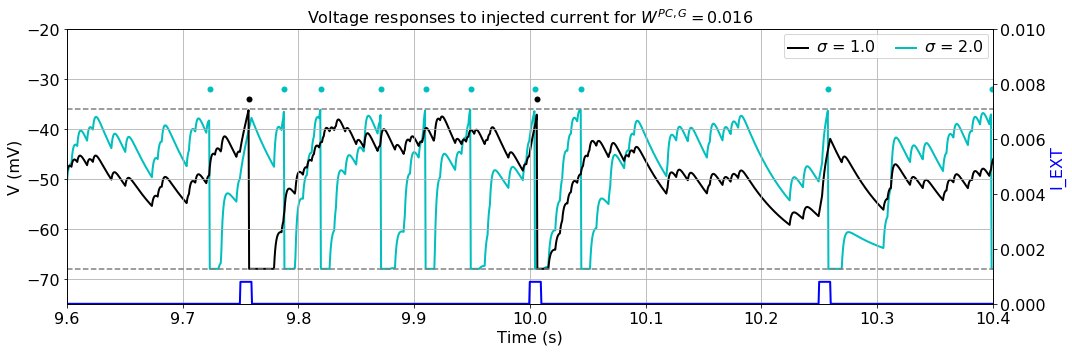

In [11]:
E.T_WDW = 0.01

# mk plots
E.COLORS_W_PC_G = [(0, 0, 0), (0, .3, 0), (0, .6, 0), (0, .9, 0)]
E.fig, E.ax = plt.subplots(1, 1, figsize=(15, 5), tight_layout=True)

# xmpl traces
E.hs = []

for E.ctr, (E.rsp, E.color) in enumerate(zip(E.rsp_xmpls, E.COLORS_XMPL)):
    
    E.label = '$\sigma$ = {0:.1f}'.format(E.rsp.sgm)
    
    E.h = E.ax.plot(
        E.t_xmpl, 1000*E.rsp.vs[:, 0], lw=2, color=E.color, label=E.label, zorder=(1-E.ctr))[0]
    E.hs.append(E.h)

    for E.spk_t_idx in E.rsp.spks[:, 0].nonzero()[0]:
        E.spk_t = E.spk_t_idx * DT
        E.y_spk = 1000*V_TH_PC + 2 + E.ctr*2
        E.ax.scatter(E.spk_t, E.y_spk, lw=0, c=E.color)
    
E.ax.axhline(1000*V_TH_PC, color='gray', ls='--')
E.ax.axhline(1000*V_R_PC, color='gray', ls='--')

E.ax.set_ylim(-75, -20)

E.ax.set_xlabel('Time (s)')
E.ax.set_ylabel('V (mV)')
E.ax.set_title('Voltage responses to injected current for $W^{PC,G} = 0.016$')
E.ax.legend(handles=E.hs, loc='upper right', ncol=2)

E.ax_twin = E.ax.twinx()
E.ax_twin.plot(E.t_xmpl, E.i_ext_xmpl, lw=2, color='b')
E.ax_twin.set_ylim(0, .01)
E.ax_twin.set_ylabel('I_EXT', color='b')

E.ax.set_xlim(9.6, 10.4)

E.ax.grid()

set_font_size(E.ax, 16)
set_font_size(E.ax_twin, 16)